In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

from modules.dataset import TrimmedVideosDataset
from modules.models.SCNN import SequentialCNN
from modules.models.RCNN import RecurrentCNN
from modules.utils import set_random_seed

In [2]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_path = '/tmp2/itsmystyle/h4_data/TrimmedVideos/video/valid/'
video_label_path = '/tmp2/itsmystyle/h4_data/TrimmedVideos/label/gt_valid.csv'

# video_path = '/tmp2/itsmystyle/h4_data/TrimmedVideos/video/train/'
# video_label_path = '/tmp2/itsmystyle/h4_data/TrimmedVideos/label/gt_train.csv'

Random seed: 42


In [3]:
dataset = TrimmedVideosDataset(
    video_path,
    video_label_path,
    max_padding=30,
    rescale_factor=(1.0 / 1),
    downsample_factor=12,
    sorting=True,
)
dataloader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=4,
    num_workers=8,
    collate_fn=dataset.collate_fn,
)

In [4]:
model = SequentialCNN()
model.load_state_dict(torch.load('../models/SCNN/model_best_0.42783_1.97644.pth.tar'))
model.to(device)
model.eval()

# model = RecurrentCNN()
# model.load_state_dict(torch.load('../models/RCNN/model_best_0.49675_1.54730.pth.tar'))
# model.to(device)
# model.eval()

SequentialCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [5]:
preds_ls = []
labels_ls = []

with torch.no_grad():
    for idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        frames = batch["frames"].to(device)
        frames_len = batch["frames_len"]
        sorted_idx = batch["sorted_idx"]
        labels = batch["labels"]

        preds = model.extract_features(frames)
#         preds = model.extract_features(frames, frames_len)
        
        preds_ls.append(preds.cpu().numpy())
        labels_ls.append(labels.cpu().numpy())

In [6]:
preds_ls = np.concatenate(preds_ls)
labels_ls = np.concatenate(labels_ls)

In [7]:
preds_ls.shape, labels_ls.shape

((2653, 64), (2653,))

In [8]:
tsne = TSNE(n_components=2, verbose=1)

In [9]:
X_tsne = tsne.fit_transform(preds_ls)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2653 samples in 0.007s...
[t-SNE] Computed neighbors for 2653 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2653
[t-SNE] Computed conditional probabilities for sample 2000 / 2653
[t-SNE] Computed conditional probabilities for sample 2653 / 2653
[t-SNE] Mean sigma: 0.595342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.112213
[t-SNE] KL divergence after 1000 iterations: 1.164174


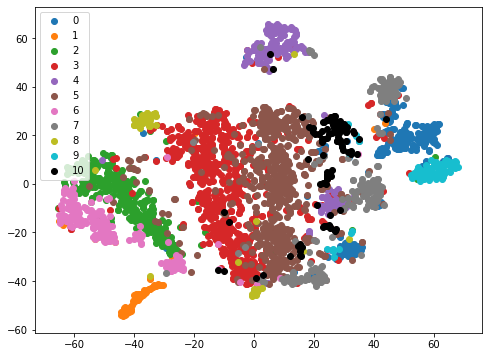

In [10]:
plt.figure(figsize=(8, 6))
for i in range(11):
    select_idxs = np.where(labels_ls == i)[0]
    plt.scatter(
        x=X_tsne[select_idxs, 0],
        y=X_tsne[select_idxs, 1],
        c="C{}".format(i) if i != 10 else 'black',
        label=i,
    )
plt.legend()